## Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from ipynb.fs.full.utility_functions import gen_data_dict, get_data, SquaredHingeLoss

np.random.seed(4)
torch.manual_seed(4)

## Process Features and Targets

### Process Features

In [2]:
# Chose features
chosen_feature = ['std_deviation', 'count', 'sum_diff', 'range_value', 'abs_skewness']
feature_input_size = len(chosen_feature)
X = pd.read_csv('../1_training_data/seq_features.csv').iloc[:, 1:][chosen_feature].to_numpy()

# verify feature input size
print(feature_input_size)

3


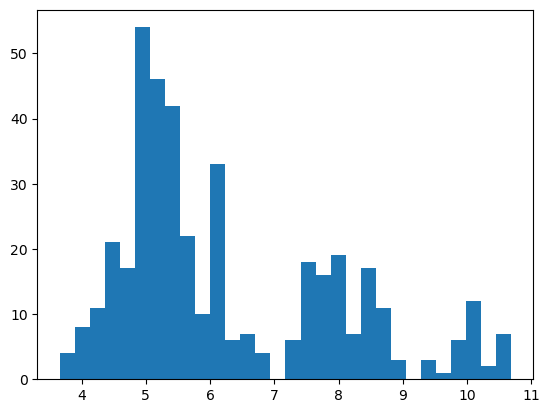

In [3]:
# analyze std_deviation
X0 = X[:, 0]
X0 = np.log(X0).reshape(-1, 1)

plt.hist(X0, bins=30)
plt.show()

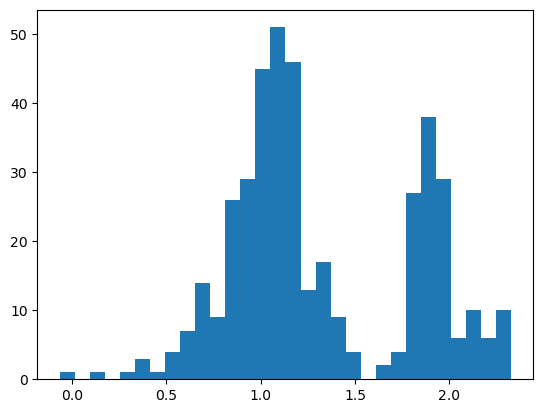

In [4]:
# analyze length
X1 = X[:, 1]
X1 = np.log(np.log(X1)).reshape(-1, 1)

plt.hist(X1, bins=30)
plt.show()

/tmp/ipykernel_1548879/1993046913.py:3: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_1548879/1993046913.py:3: RuntimeWarning: invalid value encountered in log


ValueError: supplied range of [-inf, 0.8968848191314565] is not finite

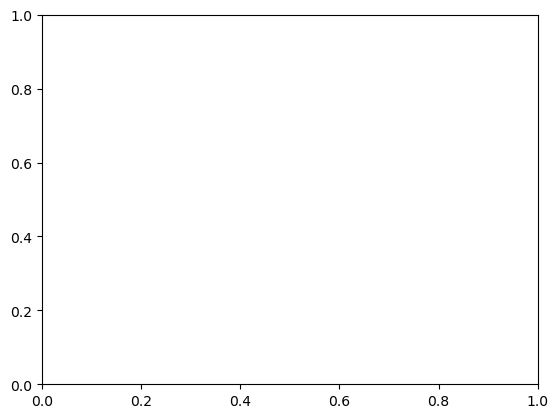

In [5]:
# analyze sum_diff
X2 = X[:, 2]
X2 = np.log(np.log(X2)).reshape(-1, 1)

plt.hist(X2, bins=30)
plt.show()

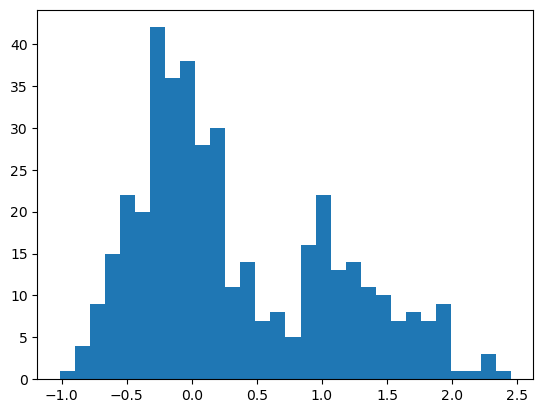

In [ ]:
# analyze range_value
X3 = X[:, 3]
X3 = np.log(X3).reshape(-1, 1)

plt.hist(X3, bins=30)
plt.show()

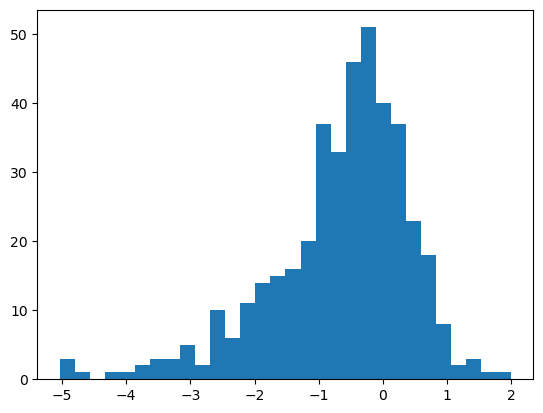

In [ ]:
# analyze abs_skewness
X4 = X[:, 4]
X4 = np.log(X4).reshape(-1, 1)

plt.hist(X4, bins=30)
plt.show()

In [6]:
# concatinate them into one features matrix
X = np.concatenate([X0, X1, X2, X3, X4], axis=1)

In [7]:
# normalize them
mean = np.mean(X, axis=0)
std_dev = np.std(X, axis=0)
X = (X-mean)/std_dev

# convert to torch tensor
features = torch.Tensor(X)

# verify the shape
print("Shape of features tensor:", features.shape)

Shape of features tensor: torch.Size([413, 3])


### Process Target Intervals

In [8]:
# data (targets)
target_df_1 = pd.read_csv('../1_training_data/target_lambda_fold1_base_10.csv')
target_df_2 = pd.read_csv('../1_training_data/target_lambda_fold2_base_10.csv')

targets_low_1  = torch.Tensor(target_df_1.iloc[:, 1:2].to_numpy())
targets_high_1 = torch.Tensor(target_df_1.iloc[:, 2:3].to_numpy())
targets_low_2  = torch.Tensor(target_df_2.iloc[:, 1:2].to_numpy())
targets_high_2 = torch.Tensor(target_df_2.iloc[:, 2:3].to_numpy())

target_fold1 = torch.cat((targets_low_1, targets_high_1), dim=1)
target_fold2 = torch.cat((targets_low_2, targets_high_2), dim=1)

# verify shape
print(target_fold1.shape, target_fold2.shape)

torch.Size([413, 2]) torch.Size([413, 2])


### Filter

In [9]:
# filter infinity
idx_fold1 = [idx for idx, item in enumerate(target_fold1) if item[0] > -torch.inf and item[1] < torch.inf]
idx_fold2 = [idx for idx, item in enumerate(target_fold2) if item[0] > -torch.inf and item[1] < torch.inf]

features_fold1 = features[idx_fold1]
features_fold2 = features[idx_fold2]

target_fold1 = target_fold1[idx_fold1]
target_fold2 = target_fold2[idx_fold2]

# test size of each training fold
print(len(features_fold1), len(target_fold1))
print(len(features_fold2), len(target_fold2))

185 185
308 308


## Model Definition

In [10]:
class DLModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size):
        super(DLModel, self).__init__()
        self.input_size    = input_size
        self.hidden_layers = hidden_layers
        self.hidden_size   = hidden_size

        if(self.hidden_layers == 0):
            self.linear_model = nn.Linear(input_size, 1)                                                        # Define linear model
        else:
            self.input_layer = nn.Linear(input_size, hidden_size)                                               # Define input layer
            self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers-1)])  # Define hidden layers
            self.output_layer = nn.Linear(hidden_size, 1)                                                       # Define output layer
        
    def forward(self, x):
        if(self.hidden_layers == 0):
            return self.linear_model(x)
        else:
            x = torch.relu(self.input_layer(x))
            for layer in self.hidden:
                x = torch.relu(layer(x))
            x = self.output_layer(x)
            return x

In [11]:
# Verify model architect
print("Linear model:\n", DLModel(5, 0, 4))
print("\nMLP model:\n",  DLModel(5, 2, 4))

Linear model:
 DLModel(
  (linear_model): Linear(in_features=5, out_features=1, bias=True)
)

MLP model:
 DLModel(
  (input_layer): Linear(in_features=5, out_features=4, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (output_layer): Linear(in_features=4, out_features=1, bias=True)
)


## Main Program

In [12]:
# function to plot train loss and val loss
def plot_loss(train_loss, val_loss, best_ite, train_set_name, val_set_name):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss,   'r', label='Validation loss')
    
    # Mark the minimum validation loss point
    if(best_ite != None):
        plt.plot(best_ite, val_loss[best_ite], 'g*', markersize=10, label=f'Min Val epoch: {best_ite: 3d}')

    plt.title('Train ' + train_set_name + " Validate " + val_set_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
def cv_learn(n_splits, X, y, n_hiddens, layer_size, show_plot, lr, n_ite):
    # Define the number of folds for cross-validation
    kf = KFold(n_splits, shuffle=True, random_state=0)

    # loss function
    loss_func = SquaredHingeLoss(margin=1)

    # learn best ite
    total_train_losses = np.zeros(n_ite)
    total_val_losses   = np.zeros(n_ite)
    for train_index, val_index in kf.split(X):

        # Split the data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Define your model
        model = DLModel(feature_input_size, n_hiddens, layer_size)

        # define optimizer
        optimizer = optim.Adam(model.parameters(), lr)

        # Training loop for the specified number of iterations
        train_losses = []
        val_losses   = []
        for i in range(n_ite):
            # training
            model.train()
            optimizer.zero_grad()
            loss = loss_func(model(X_train), y_train)
            loss.backward()
            optimizer.step()

            # validating
            model.eval()
            with torch.no_grad():
                val_loss = loss_func(model(X_val), y_val)

            # add train_loss and val_loss into arrays
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

        total_train_losses += train_losses
        total_val_losses += val_losses

    best_no_ite = np.argmin(total_val_losses)
    if(show_plot == True):
        plot_loss(total_train_losses/n_splits, total_val_losses/n_splits, best_no_ite, 'subtrain', 'val')
    
    return best_no_ite

### test cv_learn

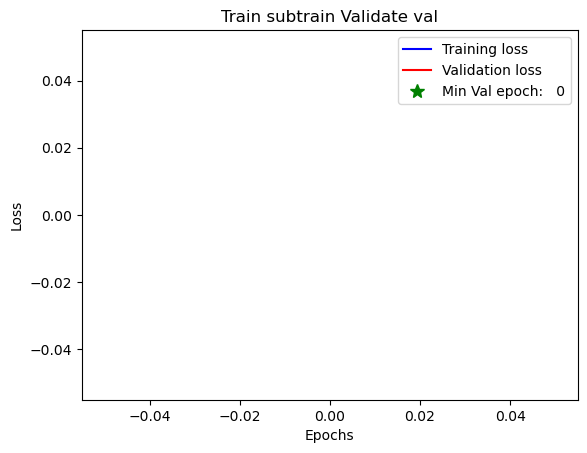

Best number of iteration: 0


In [14]:
# testing cv_learn fold 1
torch.manual_seed(0)
best_no_ite_fold1 = cv_learn(4, features_fold1, target_fold1, 2, 8, True, 0.001, 500)
print("Best number of iteration:", best_no_ite_fold1)

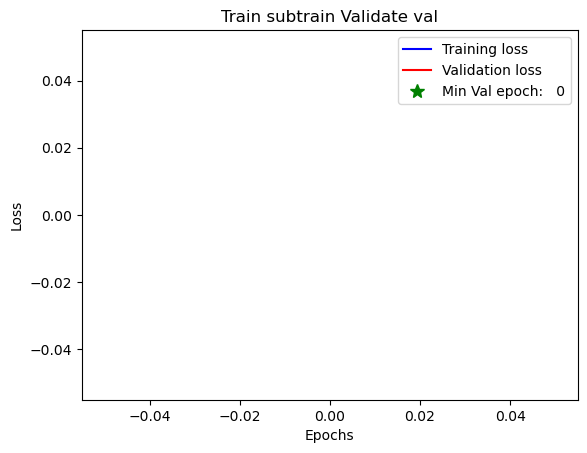

Best number of iteration: 0


In [15]:
# testing cv_learn fold 2
torch.manual_seed(0)
best_no_ite_fold2 = cv_learn(4, features_fold2, target_fold2, 2, 8, True, 0.001, 500)
print("Best number of iteration:", best_no_ite_fold2)

### testing training one fold and validating the other fold

In [ ]:
def train_test_loss_plot(X_train, X_test, y_train, y_test, train_set_name, test_set_name, hidden_layers, hidden_size, lr, n_ite):
    # loss function
    loss_func = SquaredHingeLoss(margin=1)

    # Define your model and optimizer
    model = DLModel(feature_input_size, hidden_layers, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses   = []
    for i in range(n_ite):
        # Training
        model.train()
        optimizer.zero_grad()
        loss = loss_func(model(X_train), y_train)
        loss.backward()
        optimizer.step()

        # Evaluating
        model.eval()
        with torch.no_grad():
            val_loss = loss_func(model(X_test), y_test)

        # append train_loss and val_loss
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
    
    plot_loss(train_losses, val_losses, np.argmin(val_losses), train_set_name, test_set_name)

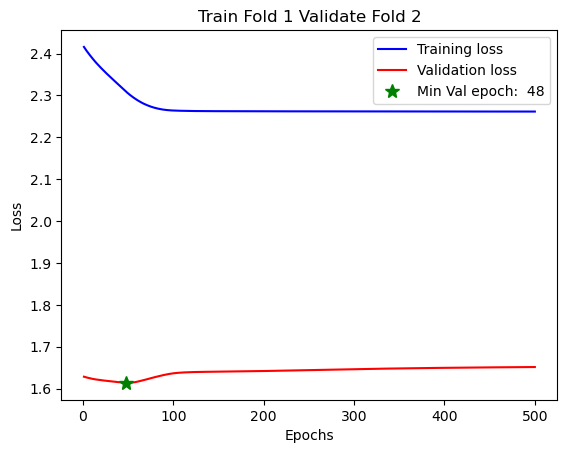

In [ ]:
torch.manual_seed(0)
train_test_loss_plot(features_fold1, features_fold2, target_fold1, target_fold2, 'Fold 1', 'Fold 2', 2, 8, 0.001, 500)

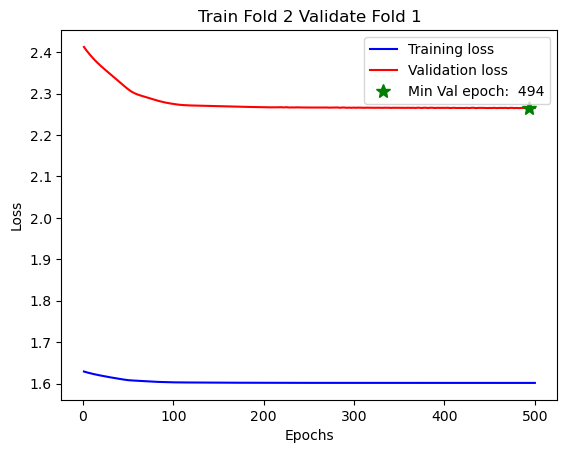

In [ ]:
torch.manual_seed(0)
train_test_loss_plot(features_fold2, features_fold1, target_fold2, target_fold1, 'Fold 2', 'Fold 1', 2, 8, 0.001, 500)

### Get Acc rate for each model

In [ ]:
def train_model(X, y, n_hiddens, layer_size, lr, n_ites):
    model = DLModel(feature_input_size, n_hiddens, layer_size)
    loss_func = SquaredHingeLoss(margin=1)
    optimizer = optim.Adam(model.parameters(), lr)

    # Training loop
    for _ in range(n_ites):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(model(X), y)
        loss.backward()
        optimizer.step()
    
    return model

In [ ]:
def get_df_stat(ldas1, ldas2, err_fold1_df, err_fold2_df, seqs, labels):
    header = ['sequenceID', 'lda_fold1', 'lda_fold2', 'fold_1_total_labels', 'fold_2_total_labels', 'fold1_err', 'fold2_err']
    rows = []
    for i in range(len(seqs)):
        # get total labels
        _, neg_start_1, _, pos_start_1, _, neg_start_2, _, pos_start_2, _ = get_data(i, seqs, labels)
        fold1_total_labels = len(neg_start_1) + len(pos_start_1)
        fold2_total_labels = len(neg_start_2) + len(pos_start_2)

        # round lambda
        ldas1 = [round(num*2)/2 for num in ldas1]
        ldas2 = [round(num*2)/2 for num in ldas2]

        # get err
        fold1_err = err_fold1_df.iloc[i][str(ldas1[i])]
        fold2_err = err_fold2_df.iloc[i][str(ldas2[i])]
        
        # add row to rows
        row = [seqs[i][0], ldas1[i], ldas2[i], fold1_total_labels, fold2_total_labels, fold1_err, fold2_err]
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=header)
    return df

In [ ]:
def try_model(full_X, X1, X2, y1, y2, config, err_fold1_df, err_fold2_df, seqs, labels):
    n_hiddens  = config['n_hiddens']
    layer_size = config['layer_size']

    best_no_ite_1 = cv_learn(3, X1, y1, n_hiddens, layer_size, False, 0.001, 500)
    best_no_ite_2 = cv_learn(3, X2, y2, n_hiddens, layer_size, False, 0.001, 500)

    model1 = train_model(X1, y1, n_hiddens, layer_size, 0.001, best_no_ite_1)
    model2 = train_model(X2, y2, n_hiddens, layer_size, 0.001, best_no_ite_2)

    with torch.no_grad():
        ldas1 = model1(full_X).numpy().reshape(-1)
        ldas2 = model2(full_X).numpy().reshape(-1)

    df = get_df_stat(ldas1, ldas2, err_fold1_df, err_fold2_df, seqs, labels)
    return df

In [ ]:
# Define the values for n_hiddens and layer_size
n_hiddens_values  = [1, 2, 3]
layer_size_values = [4, 8, 16]

# Create a list of dictionaries
configs = [{'n_hiddens': 0, 'layer_size': 0}]
configs += [{'n_hiddens': n, 'layer_size': s} for n in n_hiddens_values for s in layer_size_values]

# print configs
print(configs)

[{'n_hiddens': 0, 'layer_size': 0}, {'n_hiddens': 1, 'layer_size': 4}, {'n_hiddens': 1, 'layer_size': 8}, {'n_hiddens': 1, 'layer_size': 16}, {'n_hiddens': 2, 'layer_size': 4}, {'n_hiddens': 2, 'layer_size': 8}, {'n_hiddens': 2, 'layer_size': 16}, {'n_hiddens': 3, 'layer_size': 4}, {'n_hiddens': 3, 'layer_size': 8}, {'n_hiddens': 3, 'layer_size': 16}]


In [ ]:
# getting dataframe of error count
err_fold1_df = pd.read_csv('../1_training_data/errors_fold1_base_10.csv')
err_fold2_df = pd.read_csv('../1_training_data/errors_fold2_base_10.csv')

# getting sequences and labels data
seqs   = gen_data_dict('../0_sequences_labels/signals.gz')
labels = gen_data_dict('../0_sequences_labels/labels.gz')

In [ ]:
torch.manual_seed(0)
dfs = Parallel(n_jobs=10, verbose=1)(delayed(try_model)(features, features_fold1, features_fold2, target_fold1, target_fold2,
                                                        configs[i], err_fold1_df, err_fold2_df, seqs, labels) for i in range(len(configs)))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  3.3min remaining: 13.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  3.8min finished


In [ ]:
for i in range(len(dfs)):
    df = dfs[i]
    
    total_label_fold1 = df['fold_1_total_labels'].sum()
    total_label_fold2 = df['fold_2_total_labels'].sum()
    err1 = df['fold1_err'].sum()
    err2 = df['fold2_err'].sum()
    rate1 = (total_label_fold1 - err1)/total_label_fold1
    rate2 = (total_label_fold2 - err2)/total_label_fold2

    print("n_hiddens: %1d \t layer_size: %2d \t fold1.test: %5.2f \t fold2.test: %5.2f" % 
        (configs[i]['n_hiddens'], configs[i]['layer_size'], rate1*100, rate2*100))

n_hiddens: 0 	 layer_size:  0 	 fold1.test: 76.06 	 fold2.test: 75.00
n_hiddens: 1 	 layer_size:  4 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 1 	 layer_size:  8 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 1 	 layer_size: 16 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 2 	 layer_size:  4 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 2 	 layer_size:  8 	 fold1.test: 73.80 	 fold2.test: 75.00
n_hiddens: 2 	 layer_size: 16 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 3 	 layer_size:  4 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 3 	 layer_size:  8 	 fold1.test: 73.40 	 fold2.test: 75.00
n_hiddens: 3 	 layer_size: 16 	 fold1.test: 73.40 	 fold2.test: 75.00
